Import Libraries and Dependencies

In [1]:
import tensorflow as tf
from tensorflow import keras

import tensorflow_hub as hub

!pip -q install tensorflow_addons
import tensorflow_addons as tfa

import numpy as np
from tensorflow.random import uniform

import os
import shutil
from matplotlib import pyplot as plt

     |████████████████████████████████| 1.1 MB 25.4 MB/s 


#**Download, and Unzip Dataset**

[Dataset Link](https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset) (Dataset memiliki resolusi dan size yang tidak seragam)

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d alessiocorrado99/animals10

 98% 576M/586M [00:04<00:00, 207MB/s]
100% 586M/586M [00:04<00:00, 144MB/s]


In [3]:
data_path= 'animals10'
!unzip -q 'animals10.zip' -d {data_path}

In [4]:
os.listdir(data_path)

['translate.py', 'raw-img']

#**Load & Explore the Data**

## Rename Dataset Labels

In [5]:
from animals10.translate import translate

In [6]:
base_dir= os.path.join(data_path, 'raw-img')

Secara default nama folder menggunakan bahasa Italia, jadi terlebih dahulu kita perlu men-translate nama folder tersebut menggunakan dictionary `translate` yang berada pada file `animals10/translate.py`

In [7]:
os.listdir(base_dir), translate

(['gatto',
  'pecora',
  'scoiattolo',
  'gallina',
  'cane',
  'ragno',
  'elefante',
  'cavallo',
  'mucca',
  'farfalla'],
 {'cane': 'dog',
  'cavallo': 'horse',
  'elefante': 'elephant',
  'farfalla': 'butterfly',
  'gallina': 'chicken',
  'gatto': 'cat',
  'mucca': 'cow',
  'pecora': 'sheep',
  'scoiattolo': 'squirrel',
  'dog': 'cane',
  'elephant': 'elefante',
  'butterfly': 'farfalla',
  'chicken': 'gallina',
  'cat': 'gatto',
  'cow': 'mucca',
  'spider': 'ragno',
  'squirrel': 'scoiattolo'})

In [8]:
for i in os.listdir(base_dir):
    try:
        new_name= translate[i]
    except:
        new_name= list(translate.keys())[list(translate.values()).index(i)]

    os.rename(os.path.join(base_dir, i), os.path.join(base_dir, new_name))

Mendapatkan class labels dari nama sub-folder yang diurutkan

In [9]:
class_labels= sorted(os.listdir(os.path.join(base_dir)))

class_labels

['butterfly',
 'cat',
 'chicken',
 'cow',
 'dog',
 'elephant',
 'horse',
 'sheep',
 'spider',
 'squirrel']

## Load Data to `tf.data.Dataset` with `tf.keras.utils.image_dataset_from_directory` and Build a Data Pipeline

In [10]:
batch_size= 64
validation_split= 0.2
random_seed= 1
image_size= (224, 224)

AUTOTUNE= tf.data.experimental.AUTOTUNE

In [11]:
ds_train= keras.utils.image_dataset_from_directory(
    base_dir,
    batch_size= batch_size,
    image_size= image_size,
    shuffle= True,
    seed= random_seed,
    validation_split= validation_split,
    subset= 'training',

)

ds_validation= keras.utils.image_dataset_from_directory(
    base_dir,
    batch_size= batch_size,
    image_size= image_size,
    shuffle= True,
    seed= random_seed,
    validation_split= validation_split,
    subset= 'validation',
)

Found 26179 files belonging to 10 classes.
Using 20944 files for training.
Found 26179 files belonging to 10 classes.
Using 5235 files for validation.


In [12]:
def preprocess_image(image, label):
    image = tf.cast(image, tf.float32)
    image = image / 255.
    
    return image, label

In [13]:
ds_train= ds_train.map(preprocess_image)
ds_validation= ds_validation.map(preprocess_image).cache('/').prefetch(AUTOTUNE)

Fungsi untuk melakukan visualisasi data

In [14]:
def visualize_twenty_image(data, class_labels=None):
    image, labels= next(iter(data))
    image, labels= image.numpy(), labels.numpy()


    fig = plt.figure(figsize=(14,10))
    for i in range(5):
        for j in range(4):
            idx= (i*4)+j
            ax = fig.add_subplot(4, 5, idx+1)
            ax.imshow(image[idx])
            
            ax.set_axis_off()
            ax.set_title(f"{class_labels[labels[idx]]}")

    plt.show()

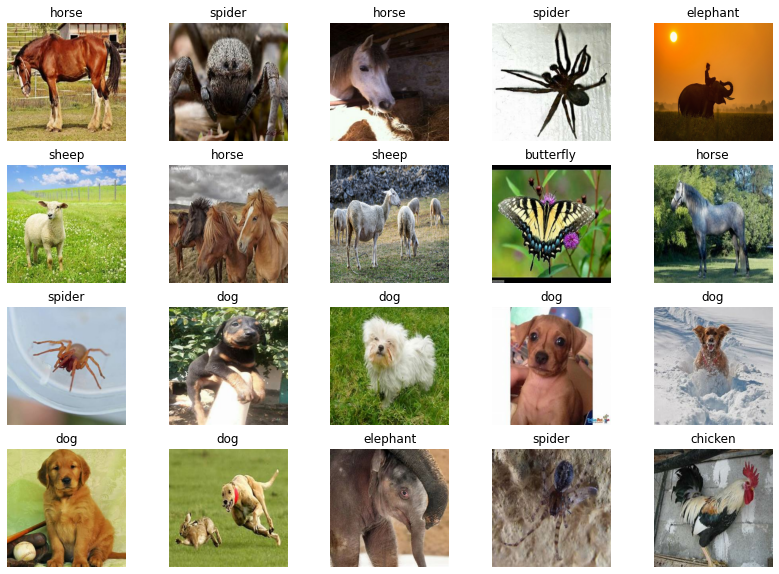

In [15]:
visualize_twenty_image(ds_train, class_labels)

In [16]:
def augmentation(image, label):
    image= tf.image.random_flip_left_right(image, seed=random_seed)
    image= tf.image.random_brightness(image, max_delta=0.15)

    if uniform((), minval=0, maxval=3, dtype=tf.int32) < 1:
        image= tf.image.random_saturation(image, lower=0.5, upper= 2)

    if uniform((), minval=0, maxval=4, dtype=tf.int32) < 1:
        image= tfa.image.rotate(image, uniform((), minval=-0.9, maxval=0.9, dtype=tf.float32), fill_mode='constant')

    image= tf.clip_by_value(image, 0, 1)

    return image, label

Menampilkan gambar setelah augmentasi

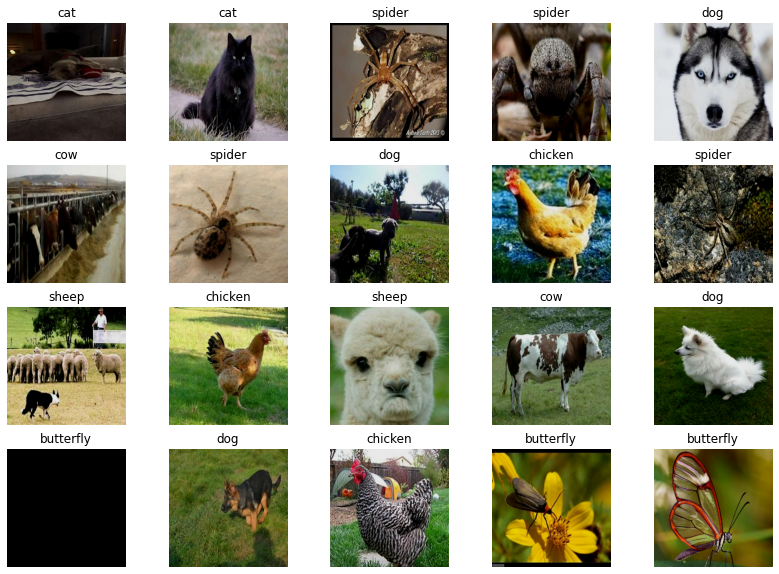

In [17]:
ds_train_aug= ds_train.map(augmentation, num_parallel_calls=AUTOTUNE)

visualize_twenty_image(ds_train_aug, class_labels)

Caching dan Prefetching data

In [18]:
ds_train_aug= ds_train_aug.shuffle(64).cache('/').prefetch(AUTOTUNE)
ds_validation= ds_validation.cache('/').prefetch(AUTOTUNE)

#**Training**

Model yang akan digunakan adalah model [ResNet50 v2](https://tfhub.dev/google/experts/bit/r50x1/in21k/chordate/1) yang telah di-fine tune pada dataset ImageNet subtree "chordate". Model ResNet50 v2 menggunakan `Conv2D Maxpooling Layer` sehingga tetap memenuhi syarat.


<img src="https://www.mdpi.com/applsci/applsci-12-02851/article_deploy/html/images/applsci-12-02851-g004.png"> </img>

In [19]:
url= 'https://tfhub.dev/google/experts/bit/r50x1/in21k/chordate/1'

base_model= hub.KerasLayer(url, input_shape=image_size+(3,), trainable=False)

Membuat model Sequential.

In [20]:
model= keras.Sequential([
    base_model,
    keras.layers.Dense(len(class_labels), 'softmax')
])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              23500352  
                                                                 
 dense (Dense)               (None, 10)                20490     
                                                                 
Total params: 23,520,842
Trainable params: 20,490
Non-trainable params: 23,500,352
_________________________________________________________________


In [22]:
opt= keras.optimizers.Adam(learning_rate=1e-3)

model.compile(
    optimizer=opt,
    loss= 'sparse_categorical_crossentropy',
    metrics=['accuracy'] 
)

reduce_lr= keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor= 0.75, patience=1, min_lr=5e-6, min_delta=5e-3)

In [23]:
history= model.fit(ds_train_aug, epochs=3, validation_data=ds_validation, callbacks=[reduce_lr])

Epoch 1/3
328/328 [==============================] - 230s 563ms/step - loss: 0.3016 - accuracy: 0.9304 - val_loss: 0.1231 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 2/3
328/328 [==============================] - 175s 535ms/step - loss: 0.1055 - accuracy: 0.9732 - val_loss: 0.0900 - val_accuracy: 0.9745 - lr: 0.0010
Epoch 3/3
328/328 [==============================] - 176s 538ms/step - loss: 0.0741 - accuracy: 0.9800 - val_loss: 0.0787 - val_accuracy: 0.9771 - lr: 0.0010


## Visualization of Loss and Accuracy During Training and Validation.

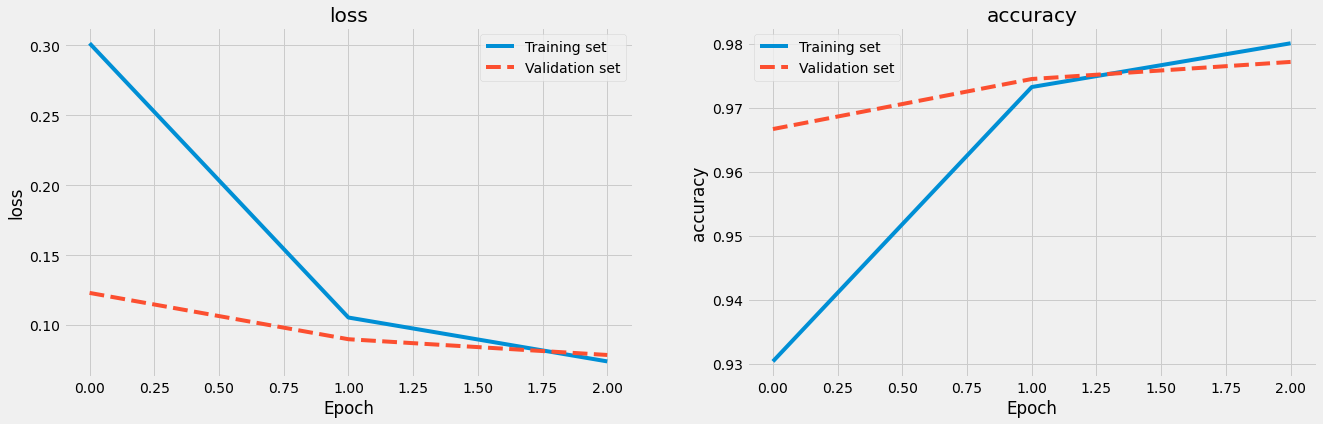

In [24]:
plt.style.use('fivethirtyeight')

plt.figure(figsize=(20, 6))

for idx, i in enumerate(['loss', 'accuracy']):
    plt.subplot(1, 2, idx+1)
    plt.title(i)
    plt.xlabel('Epoch')
    plt.ylabel(i)
    plt.plot(history.history[i], label='Training set')
    plt.plot(history.history[f'val_{i}'], label='Validation set', linestyle='--')
    plt.legend()

plt.show()

#**Deploy to TF Lite**

In [47]:
saved_model_dir= 'saved_model'

try:
    os.mkdir(saved_model_dir)
except:
    pass

In [48]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter.allow_custom_ops=True

tflite_model = converter.convert()
    
with tf.io.gfile.GFile(os.path.join(saved_model_dir, 'animals10_tflite.tflite'), 'wb') as f:
    f.write(tflite_model)

In [49]:
os.listdir(saved_model_dir)

['animals10_tflite.tflite']